In [1]:
import os
#output appears below cells, don't need plt.show every time
%matplotlib inline
from pprint import pprint
import numpy as np
import astropy.io
from astropy.io import fits
import glob
from astropy.stats import mad_std
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from pathlib import Path
import matplotlib.pyplot as plt

# Variables to Change: #

In [2]:
bias_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Bias/')
master_bias_name = 'Bias_0.000032_secs_master.fits'

dark_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Darks/')
dark_file_name = 'Dark_45_secs_001.fits'
master_dark_name = 'Dark_45_secs_master.fits'
master_dark_bias_subtracted_name = 'Dark_45_secs_master_Bias_Subtracted.fits'

flat_lum_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Luminance/')
flat_cal_lum_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Luminance Reduced/')
flat_lum_master_name = 'Flat_Luminance_6_secs_master.fits'
flat_lum_name = 'Flat_Luminance_6_secs_001.fits'

flat_red_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Red/')
flat_cal_red_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Red Reduced/')
flat_red_master_name = 'Flat_Red_20_secs_master.fits'
flat_red_name = 'Flat_Red_20_secs_001.fits'

flat_grn_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Green/')
flat_cal_grn_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Green Reduced/')
flat_grn_master_name = 'Flat_Green_20_secs_master.fits'
flat_grn_name = 'Flat_Green_20_secs_001.fits'

flat_blu_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Blue/')
flat_cal_blu_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/Blue Reduced/')
flat_blu_master_name = 'Flat_Blue_20_secs_master.fits'
flat_blu_name = 'Flat_Blue_20_secs_001.fits'

## Master Bias Frame ##

In [3]:
#create a master bias

#read in bias images
bias_ims = ccdp.ImageFileCollection(bias_path)
#checks they are all in fact bias frames
bias_set = bias_ims.files_filtered(imagetyp='Bias Frame', include_path=True)

#combines bias frames with sigma clipping on
bias_master = ccdp.combine(bias_set, method='median', sigma_clip=True, sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, 
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu')

#update header
bias_master.meta['COMBINED'] = True
#save master bias
bias_master.write(bias_path / master_bias_name, overwrite=True)
print('done')

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
done


Text(0, 0.5, 'Pixel Number')

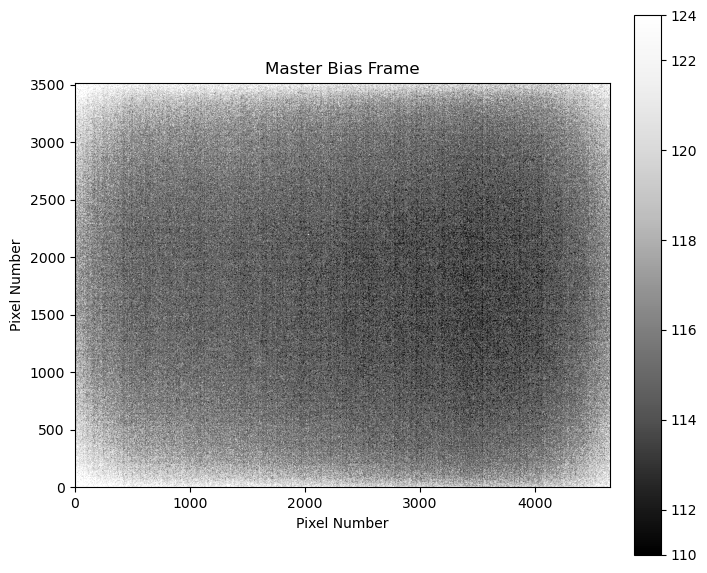

In [6]:
#plot the biases
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#note (to do with show_image):
#percl is lower percentile for astronomical stretch. percl is lower percentile edge, so if percl = 90 then 
#the bottom ten percent is streched to fill 90% of the image, with the upper 90% being squashed into the remaining
#upper 10%
#show_image(CCDData.read(bias_set[0], unit='adu').data, cmap='Greys_r', ax=ax1, fig=fig)
#ax1.set_title('Single Bias Frame')
#ax1.set_ylabel('Pixel Number')
#ax1.set_xlabel('Pixel Number')
show_image(bias_master.data, cmap='Greys_r')
plt.title('Master Bias Frame')
plt.xlabel('Pixel Number')
plt.ylabel('Pixel Number')

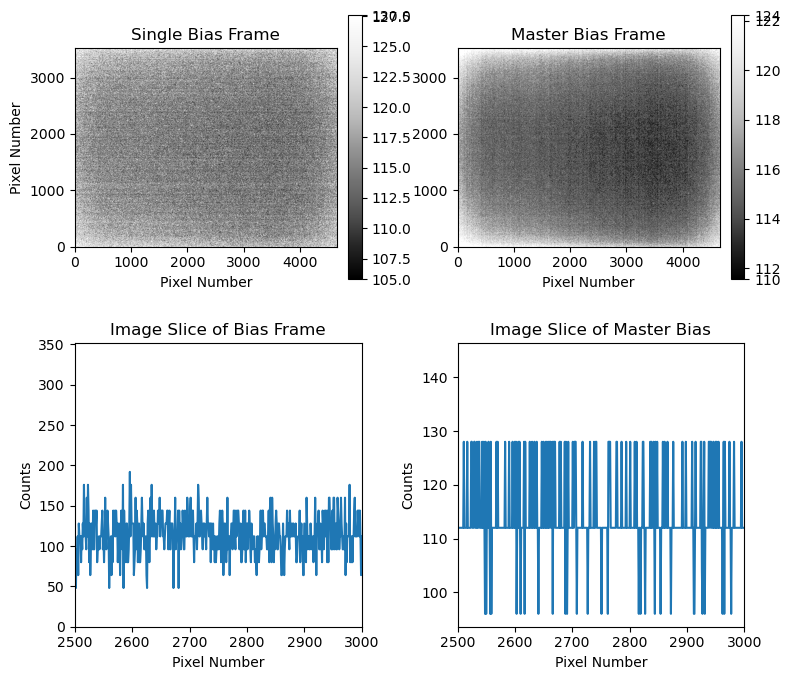

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
show_image(CCDData.read(bias_set[0], unit='adu').data, cmap='Greys_r', ax=axs[0, 0], fig=fig)
axs[0, 0].set_title('Single Bias Frame')
axs[0, 0].set_ylabel('Pixel Number')
show_image(bias_master.data, cmap='Greys_r', ax=axs[0, 1], fig=fig)
axs[0, 1].set_title('Master Bias Frame')
#axs[0, 1].set_ylabel('Pixel Number')
axs[1, 0].plot(CCDData.read(bias_set[0], unit='adu').data[1750])
axs[1, 0].set_title('Image Slice of Bias Frame')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(2500, 3000)
axs[1, 1].plot(bias_master.data[1750])
axs[1, 1].set_title('Image Slice of Master Bias')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(2500, 3000)

for ax in axs.flat:
    ax.set(xlabel='Pixel Number')
    
fig.tight_layout()

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

## Master Dark Frame ##

In [5]:
#create a master dark

#read in dark images
dark_ims = ccdp.ImageFileCollection(dark_path)
#find dark exposure time
dark_exptime = CCDData.read(dark_path / dark_file_name, unit='adu').header['exptime']
dark_exptime_unit = dark_exptime * u.second
#checks they are all in fact dark frames
dark_set = dark_ims.files_filtered(imagetyp='Dark Frame', include_path=True)

#create a master dark frame using same method from bias master
dark_master = ccdp.combine(dark_set, method='median', sigma_clip=True, sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, 
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu') 

#update header
dark_master.meta['COMBINED'] = True
#save master dark
dark_master.write(dark_path / master_dark_name, overwrite=True)

#create a bias subtracted master dark

#take master bias away from master dark to use if scaling is needed
dark_bias_subtracted = ccdp.subtract_bias(dark_master, bias_master)

#update header
dark_bias_subtracted.meta['BIAS_COR'] = True
#save bias subtracted master dark
dark_bias_subtracted.write(dark_path / master_dark_bias_subtracted_name, overwrite=True)
print('done')

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
done


Text(0.5, 1.0, 'Master Dark Frame with Bias Subtracted')

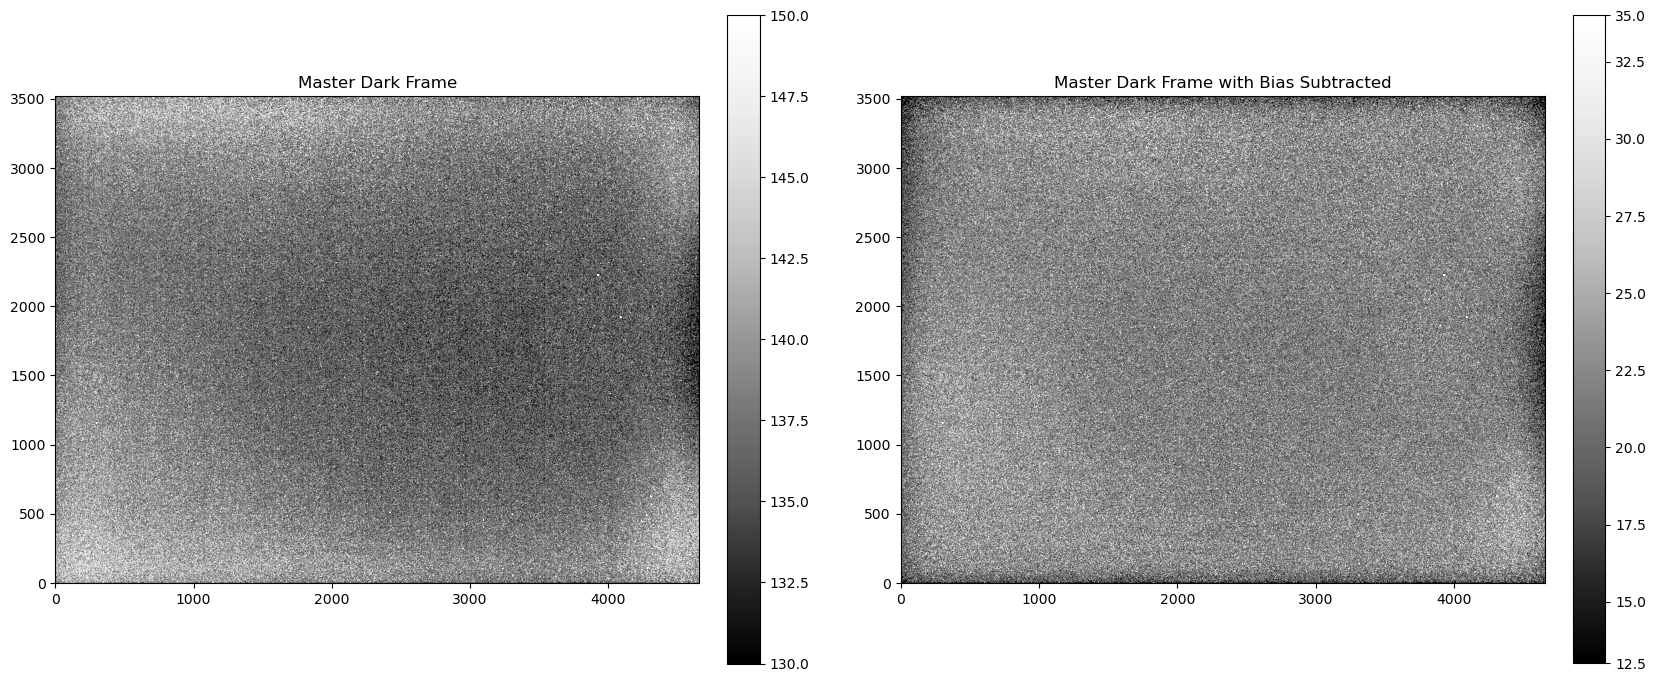

In [8]:
#plot the dark frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(dark_master.data, cmap='Greys_r', ax=ax1, fig=fig)
ax1.set_title('Master Dark Frame')
show_image(dark_bias_subtracted.data, cmap='Greys_r', ax=ax2, fig=fig)
ax2.set_title('Master Dark Frame with Bias Subtracted')

Text(0, 0.5, 'Pixel Number')

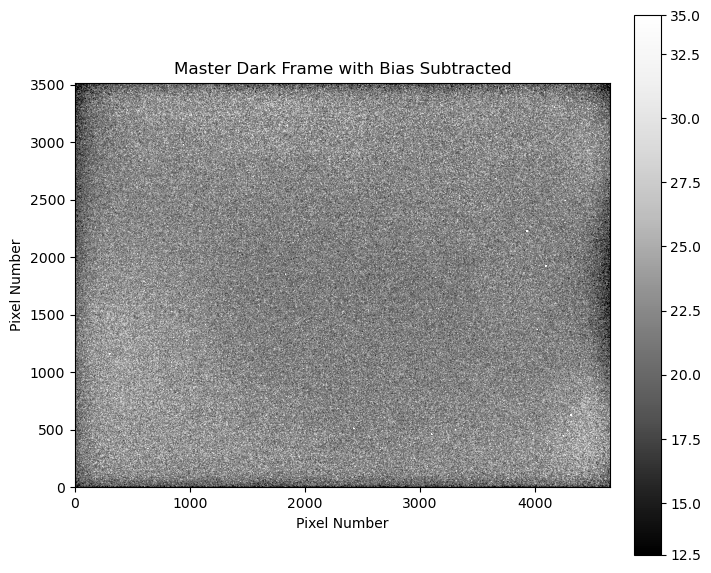

In [9]:
show_image(dark_bias_subtracted.data, cmap='Greys_r')
plt.title('Master Dark Frame with Bias Subtracted')
plt.xlabel('Pixel Number')
plt.ylabel('Pixel Number')

## Master Flat Frames ##

### Luminance - Bias + Dark Subtraction ###

In [10]:
bias_master = CCDData.read(bias_path / master_bias_name, unit = 'adu')

#read in flat images
flat_ims_lum = ccdp.ImageFileCollection(flat_lum_path)
    
for flat_data, file_name in flat_ims_lum.ccds(imagetyp='Flat Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    #read in file header
    header_info = CCDData.read(flat_lum_path / file_name, unit='adu').header
    #save exposure time
    flat_lum_exptime = header_info['exptime']
    #convert to correct units
    flat_lum_exptime_unit = flat_lum_exptime * u.second
    #delete the read in file to save memory
    del header_info
    
    #make a new file name to be associated with the reduced image
    file_name = file_name.replace('.fits', '_reduced.fits')
    #convert image data into the correct data type
    flat_data = CCDData(flat_data, unit="adu")
    
    #filter the operations done on the raw data by exposure time
    if flat_lum_exptime == dark_exptime:
        #subtract the master dark, which also serves to remove the bias
        reduced = ccdp.subtract_dark(flat_data, dark_master, scale=False)
        
    else:
        #subtract the master bias
        reduced = ccdp.subtract_bias(flat_data, bias_master)

        #scale and subtract the dark with bias removed so it's not subtracted twice
        reduced = ccdp.subtract_dark(reduced, dark_bias_subtracted, dark_exposure=dark_exptime_unit, 
                                     data_exposure=flat_lum_exptime_unit, exposure_unit=u.second, scale=True)
        
    reduced.meta['B_D_RED'] = True
    reduced.write(flat_cal_lum_path / file_name, overwrite=True)
    
print('done')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


done


### Luminance - Normalise to Median/Mean and Combination ###

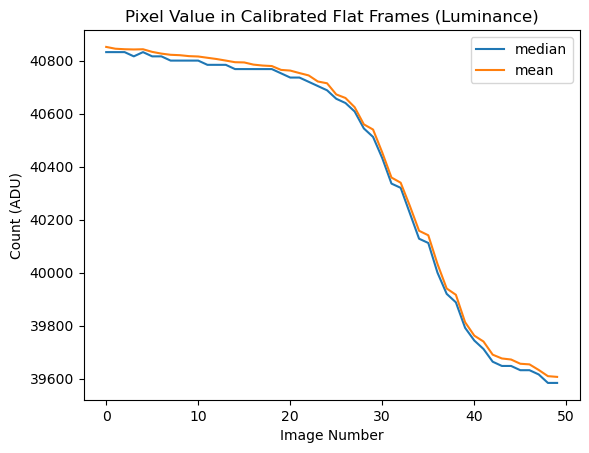

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


done


In [14]:
#read in calibrated flat fields as new files
flat_cal_lum_ims = ccdp.ImageFileCollection(flat_cal_lum_path)

#count medians and means of individual images
median_count = [np.median(data) for data in flat_cal_lum_ims.data(imagetyp='Flat Frame')]
mean_count = [np.mean(data) for data in flat_cal_lum_ims.data(imagetyp='Flat Frame')]

#remove last data point, which is the master flat (code has been rerun many times so master already exists)
del median_count[-1:]
del mean_count[-1:]

#plot to show differences
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image Number')
plt.ylabel('Count (ADU)')
plt.title('Pixel Value in Calibrated Flat Frames (Luminance)')
plt.legend()
plt.show()

#median and mean are virtually identical, but median is better to use so extreme values have less effect
#to scale data, use an inverse median function
def inverse_median(x):
    return 1/np.median(x)

#check all use the same filter
flat_cal_lum_filt = flat_cal_lum_ims.files_filtered(filter='Luminance', include_path=True)

#combine flats with sigma clipping
flat_lum_master = ccdp.combine(flat_cal_lum_filt, method='median', scale=inverse_median, sigma_clip=True, 
                           sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, sigma_clip_func=np.ma.median,
                           sigma_clip_dev_func=mad_std)
#update header
flat_lum_master.meta['COMBINED'] = True
#save as a new file
flat_lum_master.write(flat_cal_lum_path / flat_lum_master_name, overwrite=True)

print('done')

In [15]:
#show_image(flat_lum_master.data, cmap='Greys_r')
#plt.title('Master Flat Frame (Luminance Filter)')
#plt.xlabel('Pixel Number')
#plt.ylabel('Pixel Number')

Text(0.5, 1.0, 'Master Luminance Flat Frame')

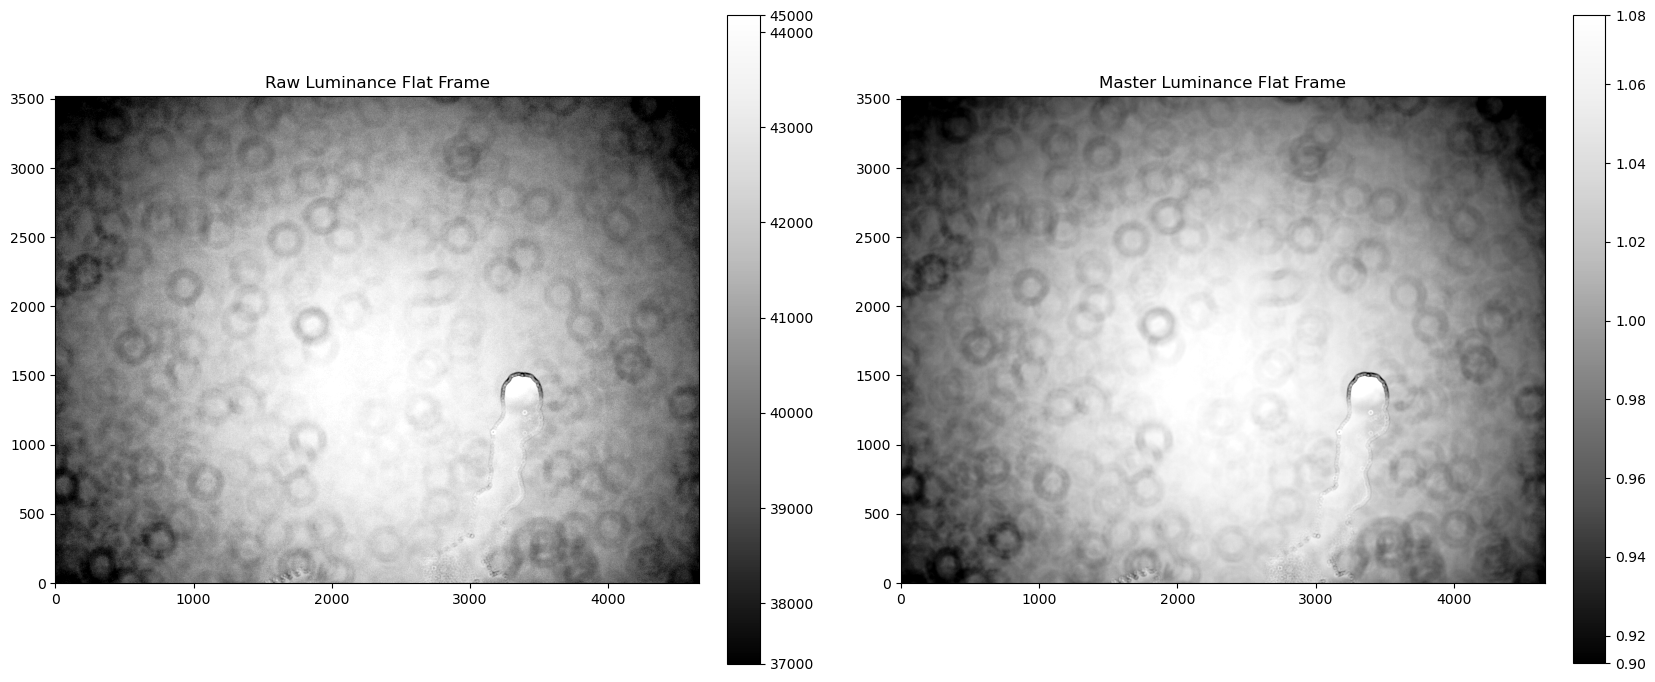

In [16]:
flat = CCDData.read(flat_lum_path / flat_lum_name, unit='adu')

#plot the dark frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(flat.data, cmap='Greys_r', ax=ax1, fig=fig)
ax1.set_title('Raw Luminance Flat Frame')
show_image(flat_lum_master.data, cmap='Greys_r', ax=ax2, fig=fig)
ax2.set_title('Master Luminance Flat Frame')

### Red - Bias and Dark Subtraction ###

In [ ]:
#read in flat images
flat_ims_red = ccdp.ImageFileCollection(flat_red_path)
    
for flat_data, file_name in flat_ims_red.ccds(imagetyp='Flat Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    #read in file header
    header_info = CCDData.read(flat_red_path / file_name, unit='adu').header
    #save exposure time
    flat_red_exptime = header_info['exptime']
    #convert to correct units
    flat_red_exptime_unit = flat_red_exptime * u.second
    #delete the read in file to save memory
    del header_info
    
    #make a new file name to be associated with the reduced image
    file_name = file_name.replace('.fits', '_reduced.fits')
    #convert image data into the correct data type
    flat_data = CCDData(flat_data, unit="adu")
    
    #filter the operations done on the raw data by exposure time
    if flat_red_exptime == dark_exptime:
        #subtract the master dark, which also serves to remove the bias
        reduced = ccdp.subtract_dark(flat_data, dark_master, scale=False)
        
    else:
        #subtract the master bias
        reduced = ccdp.subtract_bias(flat_data, bias_master)

        #scale and subtract the dark with bias removed so it's not subtracted twice
        reduced = ccdp.subtract_dark(reduced, dark_bias_subtracted, dark_exposure=dark_exptime_unit, 
                                     data_exposure=flat_red_exptime_unit, exposure_unit=u.second, scale=True)
        
    reduced.meta['B_D_RED'] = True
    reduced.write(flat_cal_red_path / file_name, overwrite=True)
    
print('done')

### Red - Normalise to Median/Mean and Combination ###

In [ ]:
#read in calibrated flat fields as new files
flat_cal_red_ims = ccdp.ImageFileCollection(flat_cal_red_path)

#count medians and means of individual images
median_count = [np.median(data) for data in flat_cal_red_ims.data(imagetyp='Flat Frame')]
mean_count = [np.mean(data) for data in flat_cal_red_ims.data(imagetyp='Flat Frame')]

#remove last data point, which is the master flat (code has been rerun many times so master already exists)
del median_count[-1:]
del mean_count[-1:]

#plot to show differences
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image Number')
plt.ylabel('Count (ADU)')
plt.title('Pixel Value in Calibrated Flat Frames (Red)')
plt.legend()
plt.show()

#check all use the same filter
flat_cal_red_filt = flat_cal_red_ims.files_filtered(filter='Red', include_path=True)

#combine flats with sigma clipping
flat_red_master = ccdp.combine(flat_cal_red_filt, method='median', scale=inverse_median, sigma_clip=True, 
                           sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, sigma_clip_func=np.ma.median,
                           sigma_clip_dev_func=mad_std)
#update header
flat_red_master.meta['COMBINED'] = True
#save as a new file
flat_red_master.write(flat_cal_red_path / flat_red_master_name, overwrite=True)

print('done')

In [ ]:
flat = CCDData.read(flat_red_path / flat_red_name, unit='adu')

#plot the dark frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(flat.data, cmap='OrRd_r', ax=ax1, fig=fig)
ax1.set_title('Raw Red Flat Frame')
show_image(flat_red_master.data, cmap='OrRd_r', ax=ax2, fig=fig)
ax2.set_title('Master Red Flat Frame')

### Green - Bias and Dark Subtraction ###

In [ ]:
#read in flat images
flat_ims_grn = ccdp.ImageFileCollection(flat_grn_path)
    
for flat_data, file_name in flat_ims_grn.ccds(imagetyp='Flat Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    #read in file header
    header_info = CCDData.read(flat_grn_path / file_name, unit='adu').header
    #save exposure time
    flat_grn_exptime = header_info['exptime']
    #convert to correct units
    flat_grn_exptime_unit = flat_grn_exptime * u.second
    #delete the read in file to save memory
    del header_info
    
    #make a new file name to be associated with the reduced image
    file_name = file_name.replace('.fits', '_reduced.fits')
    #convert image data into the correct data type
    flat_data = CCDData(flat_data, unit="adu")
    
    #filter the operations done on the raw data by exposure time
    if flat_grn_exptime == dark_exptime:
        #subtract the master dark, which also serves to remove the bias
        reduced = ccdp.subtract_dark(flat_data, dark_master, scale=False)
        
    else:
        #subtract the master bias
        reduced = ccdp.subtract_bias(flat_data, bias_master)

        #scale and subtract the dark with bias removed so it's not subtracted twice
        reduced = ccdp.subtract_dark(reduced, dark_bias_subtracted, dark_exposure=dark_exptime_unit, 
                                     data_exposure=flat_grn_exptime_unit, exposure_unit=u.second, scale=True)
        
    reduced.meta['B_D_RED'] = True
    reduced.write(flat_cal_grn_path / file_name, overwrite=True)
    
print('done')

### Green - Normalise to Median/Mean and Combination ###

In [ ]:
#read in calibrated flat fields as new files
flat_cal_grn_ims = ccdp.ImageFileCollection(flat_cal_grn_path)

#count medians and means of individual images
median_count = [np.median(data) for data in flat_cal_grn_ims.data(imagetyp='Flat Frame')]
mean_count = [np.mean(data) for data in flat_cal_grn_ims.data(imagetyp='Flat Frame')]

#remove last data point, which is the master flat (code has been rerun many times so master already exists)
del median_count[-1:]
del mean_count[-1:]

#plot to show differences
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image Number')
plt.ylabel('Count (ADU)')
plt.title('Pixel Value in Calibrated Flat Frames (Green)')
plt.legend()
plt.show()

#check all use the same filter
flat_cal_grn_filt = flat_cal_grn_ims.files_filtered(filter='Green', include_path=True)

#combine flats with sigma clipping
flat_grn_master = ccdp.combine(flat_cal_grn_filt, method='median', scale=inverse_median, sigma_clip=True, 
                           sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, sigma_clip_func=np.ma.median,
                           sigma_clip_dev_func=mad_std)
#update header
flat_grn_master.meta['COMBINED'] = True
#save as a new file
flat_grn_master.write(flat_cal_grn_path / flat_grn_master_name, overwrite=True)

print('done')

In [ ]:
flat = CCDData.read(flat_grn_path / flat_grn_name, unit='adu')

#plot the dark frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(flat.data, cmap='YlGn_r', ax=ax1, fig=fig)
ax1.set_title('Raw Green Flat Frame')
show_image(flat_grn_master.data, cmap='YlGn_r', ax=ax2, fig=fig)
ax2.set_title('Master Green Flat Frame')

### Blue - Bias and Dark Subtraction ###

In [ ]:
#read in flat images
flat_ims_blu = ccdp.ImageFileCollection(flat_blu_path)
    
for flat_data, file_name in flat_ims_blu.ccds(imagetyp='Flat Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    #read in file header
    header_info = CCDData.read(flat_blu_path / file_name, unit='adu').header
    #save exposure time
    flat_blu_exptime = header_info['exptime']
    #convert to correct units
    flat_blu_exptime_unit = flat_blu_exptime * u.second
    #delete the read in file to save memory
    del header_info
    
    #make a new file name to be associated with the reduced image
    file_name = file_name.replace('.fits', '_reduced.fits')
    #convert image data into the correct data type
    flat_data = CCDData(flat_data, unit="adu")
    
    #filter the operations done on the raw data by exposure time
    if flat_blu_exptime == dark_exptime:
        #subtract the master dark, which also serves to remove the bias
        reduced = ccdp.subtract_dark(flat_data, dark_master, scale=False)
        
    else:
        #subtract the master bias
        reduced = ccdp.subtract_bias(flat_data, bias_master)

        #scale and subtract the dark with bias removed so it's not subtracted twice
        reduced = ccdp.subtract_dark(reduced, dark_bias_subtracted, dark_exposure=dark_exptime_unit, 
                                     data_exposure=flat_blu_exptime_unit, exposure_unit=u.second, scale=True)
        
    reduced.meta['B_D_RED'] = True
    reduced.write(flat_cal_blu_path / file_name, overwrite=True)
    
print('done')

### Blue - Normalise to Median/Mean and Combination ###

In [ ]:
#read in calibrated flat fields as new files
flat_cal_blu_ims = ccdp.ImageFileCollection(flat_cal_blu_path)

#count medians and means of individual images
median_count = [np.median(data) for data in flat_cal_blu_ims.data(imagetyp='Flat Frame')]
mean_count = [np.mean(data) for data in flat_cal_blu_ims.data(imagetyp='Flat Frame')]

#remove last data point, which is the master flat (code has been rerun many times so master already exists)
del median_count[-1:]
del mean_count[-1:]

#plot to show differences
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image Number')
plt.ylabel('Count (ADU)')
plt.title('Pixel Value in Calibrated Flat Frames (Blue)')
plt.legend()
plt.show()

#check all use the same filter
flat_cal_blu_filt = flat_cal_blu_ims.files_filtered(filter='Blue', include_path=True)

#combine flats with sigma clipping
flat_blu_master = ccdp.combine(flat_cal_blu_filt, method='median', scale=inverse_median, sigma_clip=True, 
                           sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, sigma_clip_func=np.ma.median,
                           sigma_clip_dev_func=mad_std)
#update header
flat_blu_master.meta['COMBINED'] = True
#save as a new file
flat_blu_master.write(flat_cal_blu_path / flat_blu_master_name, overwrite=True)

print('done')

In [ ]:
flat = CCDData.read(flat_blu_path / flat_blu_name, unit='adu')

#plot the dark frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(flat.data, cmap='BuPu_r', ax=ax1, fig=fig)
ax1.set_title('Raw Blue Flat Frame')
show_image(flat_blu_master.data, cmap='BuPu_r', ax=ax2, fig=fig)
ax2.set_title('Master Blue Flat Frame')

In [5]:
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriate stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)